In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import cPickle as pickle
import multiprocessing
import scipy.special
import numpy as np
import numpy.fft as fft
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')

In [3]:
import plotly.plotly as py
from plotly.tools import FigureFactory as FF
import plotly.graph_objs as go

In [4]:
from conversion import rotation_matrix_fromq,rotation_matrix_from_params,rotation_matrix_to_q,angles_from_q
from utils import to_radian,res_to_rad,ax_to_w,rep_to_angle

In [5]:
# Get All Axes of Rotations
path = '/Users/zyzdiana/Dropbox/THESIS/July_26_2016_navs/'
resolutions = ['6_4mm', '8mm', '10mm']
ranges = ['0_5_to_2_5','3_0_to_5_0','2_5_to_12_5','15_to_25']
files = os.listdir(path)
axes_dict = {}
for f in files[1:]:
    rot_ax = f.split('_')[2]
    trans_ax = f.split('_')[10]
    if not axes_dict.has_key(rot_ax):
        axes_dict[rot_ax] = trans_ax
print axes_dict
keys = axes_dict.keys()

rot_axes = ['xz', 'y', 'yz', 'xy', 'x', 'z']
ax_to_idx = {}
for rot_ax in rot_axes:
    ax_to_idx[rot_ax] = rot_axes.index(rot_ax)
print ax_to_idx

{'xz': 'xy', 'y': 'z', 'yz': 'xy', 'xy': 'xy', 'x': 'z', 'z': 'z'}
{'xy': 3, 'xz': 0, 'yz': 2, 'y': 1, 'x': 4, 'z': 5}


# Figure 1 Saggital Slices

In [6]:
oct13_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_10.p','rb'))
oct13_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_8.p','rb'))
oct13_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_6_4.p','rb'))

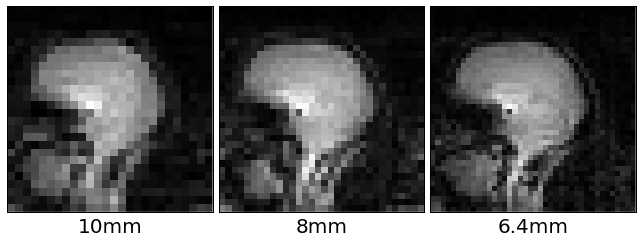

In [7]:
fontsize = 20

vol_10 = oct13_dict_10[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
vol_8 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
vol_6_4 = oct13_dict_6_4[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]

fig, ax = plt.subplots(1,3)
fig.set_figwidth(8.8)
fig.set_figheight(3)
ax[0].imshow(np.flipud(vol_10[13,:,:].T), interpolation = 'None', cmap='gray')
#ax[0].set_title('',fontsize=fontsize)
ax[0].set_xlabel('10mm',fontsize=fontsize)
ax[1].imshow(np.flipud(vol_8[16,:,:].T), interpolation = 'None', cmap='gray')
#ax[1].set_title('HF rotation',fontsize=20)
ax[1].set_xlabel('8mm',fontsize=fontsize)
ax[2].imshow(np.flipud(vol_6_4[20,:,:].T), interpolation = 'None', cmap='gray')
#ax[2].set_title('AP rotation',fontsize=fontsize)
ax[2].set_xlabel('6.4mm',fontsize=fontsize)
[ax[i].get_xaxis().set_ticks([]) for i in xrange(3)]
[ax[i].get_yaxis().set_ticks([]) for i in xrange(3)]
fig.savefig('/Users/zyzdiana/Github/ISMRM2017/figure1.png')
plt.tight_layout(pad=0, w_pad=0.1, h_pad=0.1)
plt.show()

# Figure 2 & 3 violin plots for small and large rotations

## Get all results from C++ code

In [10]:
dates = ['Oct_13_navs', 'June_8_2016_navs', 'July_26_2016_Navs', 'July_15_2016_Navs']
interps = ['linear','cubic','cubicBSpline']
data_ls_all = []
output_path = '/Users/zyzdiana/Desktop/C_output_oribi/'
for algo in xrange(6):
    print 'algo',algo
    data_ls = []
    for interp in interps:
        print interp,
        for date in dates:
            print date,
            path = os.path.join(output_path, date)
            data_ls.append(compute_RMS(path, interp, algo, 6, range_start = 0, range_end = 2))
        print
    data_ls_all.append(data_ls)
    
pickle.dump(data_ls_all,open('data_ls_all.p','wb'))

algo 0
linear Oct_13_navs June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
cubic Oct_13_navs June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
cubicBSpline Oct_13_navs June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
algo 1
linear Oct_13_navs June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
cubic Oct_13_navs June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
cubicBSpline Oct_13_navs June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
algo 2
linear Oct_13_navs June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
cubic Oct_13_navs June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
cubicBSpline Oct_13_navs June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
algo 3
linear Oct_13_navs June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
cubic Oct_13_navs June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
cubicBSpline Oct_13_navs June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
algo 4
linear Oct_13_navs June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
cubic Oct

In [77]:
dates = ['June_8_2016_navs', 'July_26_2016_Navs', 'July_15_2016_Navs']
interps = ['linear','cubic','cubicBSpline']
large_rot_data_ls_all = []
output_path = '/Users/zyzdiana/Desktop/C_output_oribi/'
for algo in xrange(6):
    print 'algo',algo
    data_ls = []
    for interp in interps:
        print interp,
        for date in dates:
            print date,
            path = os.path.join(output_path, date)
            data_ls.append(compute_RMS(path, interp, algo, 6, range_start = 2, range_end = 4, keys = ['x']))
        print
    large_rot_data_ls_all.append(data_ls)
pickle.dump(large_rot_data_ls_all,open('large_rot_data_ls_all.p','wb'))

algo 0
linear June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
cubic June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
cubicBSpline June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
algo 1
linear June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
cubic June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
cubicBSpline June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
algo 2
linear June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
cubic June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
cubicBSpline June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
algo 3
linear June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
cubic June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
cubicBSpline June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
algo 4
linear June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
cubic June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
cubicBSpline June_8_2016_navs July_26_2016_Navs July_15_2016_Navs
algo 5
linear June_8_2016_navs July_26_2

In [6]:
data_ls_all = pickle.load(open('data_ls_all.p','rb'))
large_rot_data_ls_all = pickle.load(open('large_rot_data_ls_all.p','rb'))

In [ ]:
# 1. RMS_ls_6_4, 2. RMS_ls_8, 3. RMS_ls_10

## Make Dataframe for Violin Plots

In [7]:
import pandas as pd
labels = ['10mm<br>Trilinear','10mm<br>Tricubic','10mm<br>Cubic<br>B-spline',
          '8mm<br>Trilinear','8mm<br>Tricubic','8mm<br>Cubic<br>B-spline',
          '6.4mm<br>Trilinear','6.4mm<br>Tricubic','6.4mm<br>Cubic<br>B-spline']

columns = ['Label','RMS','RMS_Rotation','RMS_Translation','Max_Dis','Max_Dis_R','RMS_trans_R','Iterations','Time']

In [8]:
labels = ['10mm<br>Trilinear','10mm<br>Tricubic','10mm',
          '8mm<br>Trilinear','8mm<br>Tricubic','8mm',
          '6.4mm<br>Trilinear','6.4mm<br>Tricubic','6.4mm']

In [9]:
num_subject = 3
Labels_ls = []
for l in [labels[2]] + [labels[5]] + [labels[8]]:
    for subj in xrange(1,num_subject+1):
        for j in xrange(420):
            Labels_ls.append(l+'<br>Subject %s' %subj)
print len(Labels_ls)

num_subject = 2
Labels_ls_large_rot = []
for l in [labels[2]] + [labels[5]] + [labels[8]]:
    for subj in xrange(1,num_subject+1):
        for j in xrange(70):
            Labels_ls_large_rot.append(l+'<br>Subject %s' %(subj+1))
print len(Labels_ls_large_rot)

Pineapple_label = []
for l in [labels[2]] + [labels[5]] + [labels[8]]:
    for j in xrange(420):
        Pineapple_label.append(l+'<br>Pineapple')
print len(Pineapple_label)

Pineapple_label_large_rot = []
for l in [labels[2]] + [labels[5]] + [labels[8]]:
    for j in xrange(70):
        Pineapple_label_large_rot.append(l+'<br>Pineapple')
print len(Pineapple_label_large_rot)

3780
420
1260
210


In [10]:
num_subject = 4
Labels_ls_all = []
for l in [labels[2]] + [labels[5]] + [labels[8]]:
    for subj in xrange(1,num_subject+1):
        if subj != 4:
            for j in xrange(420):
                Labels_ls_all.append(l+'<br>Subject %s' %subj) 
        else:
            for j in xrange(420):
                Labels_ls_all.append(l+'<br>Pineapple')
print len(Labels_ls_all)

5040


In [11]:
def get_subjects_df(data_ls, Labels_ls = Labels_ls, num_subject = 3):
    subjects_df = pd.DataFrame(columns = columns)
    subjects_df[columns[0]] = Labels_ls
    for idx, col in enumerate(columns[1:]):
        col_vals = []
        for res in [3,2,1]:
            for interp in xrange(2,3):
                for subj in xrange(num_subject):
                    col_vals += data_ls[interp*num_subject+subj][res+(idx*3)]
        subjects_df[col] = col_vals
    return subjects_df

def get_pineapple_df(data_ls, Pineapple_label = Pineapple_label, pineapple_idx = 3, num_subject = 4):
    pineapple_df = pd.DataFrame(columns = columns)
    pineapple_df[columns[0]] = Pineapple_label
    for idx, col in enumerate(columns[1:]):
        col_vals = []
        for res in [3,2,1]:
            for interp in xrange(2,3):
                col_vals += data_ls[interp*num_subject+pineapple_idx][res+(idx*3)]
        pineapple_df[col] = col_vals
    return pineapple_df

def get_subjects_df_all(data_ls, Labels_ls = Labels_ls_all, num_subject = 4):
    subjects_df = pd.DataFrame(columns = columns)
    subjects_df[columns[0]] = Labels_ls
    for idx, col in enumerate(columns[1:]):
        col_vals = []
        for res in [3,2,1]:
            for interp in xrange(2,3):
                for subj in xrange(num_subject):
                    col_vals += data_ls[interp*num_subject+subj][res+(idx*3)]
        subjects_df[col] = col_vals
    return subjects_df

In [12]:
df = get_subjects_df_all(data_ls_all[0])
df.head()

,Label,RMS,RMS_Rotation,RMS_Translation,Max_Dis,Max_Dis_R,RMS_trans_R,Iterations,Time
0,10mm<br>Subject 1,0.121683,0.048166,0.109453,0.152710,0.084065,0.053167,1,19.156
1,10mm<br>Subject 1,0.127343,0.059814,0.108889,0.181633,0.104394,0.066025,1,18.306
2,10mm<br>Subject 1,0.181668,0.098754,0.145328,0.300865,0.172359,0.109009,1,18.589
3,10mm<br>Subject 1,0.269347,0.160629,0.202753,0.471047,0.280351,0.177309,1,18.775
4,10mm<br>Subject 1,0.350618,0.212405,0.260692,0.621929,0.370717,0.234462,1,18.866


## Violin Plot

In [13]:
from plotly.offline import plot
import plotly.graph_objs as go

In [14]:
colors_dict = {'10mm<br>Subject 1':'rgb(76, 104, 250)',
                   '10mm<br>Subject 2':'rgb(25, 200, 120)',
                   '10mm<br>Subject 3' :'rgb(236, 0, 67)',
                   '8mm<br>Subject 1' : 'rgb(76, 104, 250)',
                   '8mm<br>Subject 2' : 'rgb(25, 200, 120)',
                   '8mm<br>Subject 3' : 'rgb(236, 0, 67))',
                   '6.4mm<br>Subject 1' : 'rgb(76, 104, 250)',
                   '6.4mm<br>Subject 2' : 'rgb(25, 200, 120)',
                   '6.4mm<br>Subject 3' : 'rgb(236, 0, 67)'}

In [15]:
colors_dict_large_rot = {'10mm<br>Subject 2':'rgb(25, 200, 120)',
                   '10mm<br>Subject 3':'rgb(236, 0, 67)',
                   '8mm<br>Subject 2' : 'rgb(25, 200, 120)',
                   '8mm<br>Subject 3' : 'rgb(236, 0, 67)',
                   '6.4mm<br>Subject 2' : 'rgb(25, 200, 120)',
                   '6.4mm<br>Subject 3' : 'rgb(236, 0, 67)',}

### Small Rotations

In [20]:
algo = 5
fig = FF.create_violin(get_subjects_df(data_ls_all[algo]), data_header='RMS', group_header='Label', 
                       height=600, width=1000, title='',colors = colors_dict)
plot(fig, filename='/Users/zyzdiana/Github/ISMRM2017/RMS_algo%s.html' % (algo+1), auto_open = True)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]  [ (1,3) x3,y1 ]  [ (1,4) x4,y1 ]  [ (1,5) x5,y1 ]  [ (1,6) x6,y1 ]  [ (1,7) x7,y1 ]  [ (1,8) x8,y1 ]  [ (1,9) x9,y1 ]



'file:///Users/zyzdiana/Github/ISMRM2017/RMS_algo6.html'

In [16]:
algo = 5
fig = FF.create_violin(get_subjects_df(data_ls_all[algo]), data_header='RMS', group_header='Label', 
                       height=600, width=1000, title='',colors = colors_dict)
py.image.save_as(fig, filename = '/Users/zyzdiana/Desktop/figure2.svg')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]  [ (1,3) x3,y1 ]  [ (1,4) x4,y1 ]  [ (1,5) x5,y1 ]  [ (1,6) x6,y1 ]  [ (1,7) x7,y1 ]  [ (1,8) x8,y1 ]  [ (1,9) x9,y1 ]



In [57]:
algo = 5
fig = FF.create_violin(get_pineapple_df(data_ls_all[algo]), data_header='RMS', group_header='Label', 
                       height=600, width=1000, title='')
plot(fig, filename='/Users/zyzdiana/Github/ISMRM2017/RMS_algo%s_pinapple.html' % (algo+1), auto_open = True)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]  [ (1,3) x3,y1 ]



'file:///Users/zyzdiana/Github/ISMRM2017/RMS_algo6_pinapple.html'

### Large Rotations

In [21]:
algo = 5
fig = FF.create_violin(get_subjects_df(large_rot_data_ls_all[algo], Labels_ls_large_rot, 2), data_header='RMS', 
                       group_header='Label', height=600, width=1000, title='', colors = colors_dict_large_rot)
plot(fig, filename='/Users/zyzdiana/Github/ISMRM2017/RMS_algo%s_large_rot.html' % (algo+1), auto_open = True)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]  [ (1,3) x3,y1 ]  [ (1,4) x4,y1 ]  [ (1,5) x5,y1 ]  [ (1,6) x6,y1 ]



'file:///Users/zyzdiana/Github/ISMRM2017/RMS_algo6_large_rot.html'

In [17]:
algo = 5
fig = FF.create_violin(get_subjects_df(large_rot_data_ls_all[algo], Labels_ls_large_rot, 2), data_header='RMS', 
                       group_header='Label', height=600, width=1000, title='', colors = colors_dict_large_rot)
py.image.save_as(fig, filename = '/Users/zyzdiana/Desktop/figure3.svg')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]  [ (1,3) x3,y1 ]  [ (1,4) x4,y1 ]  [ (1,5) x5,y1 ]  [ (1,6) x6,y1 ]



In [82]:
algo = 5
fig = FF.create_violin(get_pineapple_df(large_rot_data_ls_all[algo],Pineapple_label_large_rot, 2, 3), data_header='RMS', group_header='Label', 
                       height=600, width=1000, title='')
plot(fig, filename='/Users/zyzdiana/Github/ISMRM2017/RMS_algo%s_pinapple_large_rot.html' % (algo+1), auto_open = True)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]  [ (1,3) x3,y1 ]



'file:///Users/zyzdiana/Github/ISMRM2017/RMS_algo6_pinapple_large_rot.html'

# Table 2 Wilcoxon Test Results

In [70]:
from scipy.stats import rankdata
def signed_rank_test(array1,array2):
    # Compute difference
    diff = np.array(array1)-np.array(array2)
    # record signs
    sign = np.sign(diff)
    # take absolute value
    abs_diff = abs(diff)

    # find indexes that sort an array
    indexes = np.argsort(abs_diff)

    # sorted difference and signs
    sorted_diff_all = abs_diff[indexes]
    sorted_sign_all = sign[indexes]

    # delete zero differences
    mask = sorted_diff_all >= 1e-10
    sorted_diff = sorted_diff_all[mask]
    sorted_sign = sorted_sign_all[mask]

    # Find max W
    N = len(sorted_diff)
    max_W = N*(N+1)/2.
    sigma_w = np.sqrt(N*(N+1)*(2*N+1)/6.)
    #print N, max_W

    # final difference
    final_diff = sorted_diff*sorted_sign

    # find rank
    rank = rankdata(sorted_diff)

    # final rank
    final_rank = sorted_sign*rank

    # score
    w = np.sum(final_rank)
    
    # z score
    z = (w-0.5)/sigma_w
    return N, max_W, w, z

In [71]:
algo = 5
RMS_Bspline_6_4 = data_ls_all[algo][8][1]+data_ls_all[algo][9][1]+data_ls_all[algo][10][1]
RMS_Bspline_8 = data_ls_all[algo][8][2]+data_ls_all[algo][9][2]+data_ls_all[algo][10][2]
RMS_Bspline_10 =  data_ls_all[algo][8][3]+data_ls_all[algo][9][3]+data_ls_all[algo][10][3]

In [72]:
# Cubic B-spline RMS from 10mm to 8mm (8mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_Bspline_8,RMS_Bspline_10)
print 'Cubic B-spline RMS from 10mm to 8mm (8mm - 10mm)', N, max_W, w, z

# Cubic B-spline RMS from 8mm to 6.4mm (6.4mm - 8mm)
N, max_W, w, z = signed_rank_test(RMS_Bspline_6_4,RMS_Bspline_8)
print 'Cubic B-spline RMS from 8mm to 6.4mm (6.4mm - 8mm)', N, max_W, w, z

# Cubic B-spline RMS from 10mm to 6.4mm (6.4mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_Bspline_6_4,RMS_Bspline_10)
print 'Cubic B-spline RMS from 10mm to 6.4mm (6.4mm - 10mm)', N, max_W, w, z

Cubic B-spline RMS from 10mm to 8mm (8mm - 10mm) 1260 794430.0 -189464.0 -7.33287420212
Cubic B-spline RMS from 8mm to 6.4mm (6.4mm - 8mm) 1260 794430.0 -90158.0 -3.48941853884
Cubic B-spline RMS from 10mm to 6.4mm (6.4mm - 10mm) 1260 794430.0 -266420.0 -10.3113143167


In [73]:
algo = 5
RMS_Bspline_6_4 = large_rot_data_ls_all[algo][7][1]+large_rot_data_ls_all[algo][8][1]
RMS_Bspline_8 = large_rot_data_ls_all[algo][7][2]+large_rot_data_ls_all[algo][8][2]
RMS_Bspline_10 =  large_rot_data_ls_all[algo][7][3]+large_rot_data_ls_all[algo][8][3]

In [74]:
# Cubic B-spline RMS from 10mm to 8mm (8mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_Bspline_8,RMS_Bspline_10)
print 'Cubic B-spline RMS from 10mm to 8mm (8mm - 10mm)', N, max_W, w, z

# Cubic B-spline RMS from 8mm to 6.4mm (6.4mm - 8mm)
N, max_W, w, z = signed_rank_test(RMS_Bspline_6_4,RMS_Bspline_8)
print 'Cubic B-spline RMS from 8mm to 6.4mm (6.4mm - 8mm)', N, max_W, w, z

# Cubic B-spline RMS from 10mm to 6.4mm (6.4mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_Bspline_6_4,RMS_Bspline_10)
print 'Cubic B-spline RMS from 10mm to 6.4mm (6.4mm - 10mm)', N, max_W, w, z

Cubic B-spline RMS from 10mm to 8mm (8mm - 10mm) 140 9870.0 3626.0 3.77065502203
Cubic B-spline RMS from 8mm to 6.4mm (6.4mm - 8mm) 140 9870.0 -9086.0 -9.45029840234
Cubic B-spline RMS from 10mm to 6.4mm (6.4mm - 10mm) 140 9870.0 -6582.0 -6.84604514757


In [77]:
algo = 5
RMS_Bspline_s1 = data_ls_all[algo][8][1] + data_ls_all[algo][8][2] + data_ls_all[algo][8][3]
RMS_Bspline_s2 = data_ls_all[algo][9][1] + data_ls_all[algo][9][2] + data_ls_all[algo][9][3]
RMS_Bspline_s3 = data_ls_all[algo][10][1] + data_ls_all[algo][10][2] + data_ls_all[algo][10][3]
RMS_Bspline_p = data_ls_all[algo][11][1] + data_ls_all[algo][11][2] + data_ls_all[algo][11][3]

In [78]:
# Cubic B-spline RMS from Pineapple to Subject1 (Subject1 - Pineapple)
N, max_W, w, z = signed_rank_test(RMS_Bspline_s1,RMS_Bspline_p)
print 'Cubic B-spline RMS from Pineapple to Subject1 (Subject1 - Pineapple)', N, max_W, w, z

# Cubic B-spline RMS from Pineapple to Subject2 (Subject2 - Pineapple)
N, max_W, w, z = signed_rank_test(RMS_Bspline_s2,RMS_Bspline_p)
print 'Cubic B-spline RMS from Pineapple to Subject2 (Subject2 - Pineapple)', N, max_W, w, z

# Cubic B-spline RMS from Pineapple to Subject3 (Subject3 - Pineapple)
N, max_W, w, z = signed_rank_test(RMS_Bspline_s3,RMS_Bspline_p)
print 'Cubic B-spline RMS from Pineapple to Subject3 (Subject3 - Pineapple)', N, max_W, w, z

Cubic B-spline RMS from Pineapple to Subject1 (Subject1 - Pineapple) 1260 794430.0 645474.0 24.9818619124
Cubic B-spline RMS from Pineapple to Subject2 (Subject2 - Pineapple) 1260 794430.0 473192.0 18.3140046975
Cubic B-spline RMS from Pineapple to Subject3 (Subject3 - Pineapple) 1260 794430.0 432628.0 16.7440498556


In [79]:
# Cubic B-spline RMS from Subject1 to Subject2 (Subject2 - Subject1)
N, max_W, w, z = signed_rank_test(RMS_Bspline_s2,RMS_Bspline_s1)
print 'Cubic B-spline RMS from Subject1 to Subject2 (Subject2 - Subject1)', N, max_W, w, z

# Cubic B-spline RMS from Subject2 to Subject3 (Subject3 - Subject2)
N, max_W, w, z = signed_rank_test(RMS_Bspline_s3,RMS_Bspline_s2)
print 'Cubic B-spline RMS from Subject2 to Subject3 (Subject3 - Subject2)', N, max_W, w, z

# Cubic B-spline RMS from Subject3 to Subject1 (Subject3 - Subject1)
N, max_W, w, z = signed_rank_test(RMS_Bspline_s1,RMS_Bspline_s3)
print 'Cubic B-spline RMS from Subject3 to Subject1 (Subject1 - Subject3)', N, max_W, w, z

Cubic B-spline RMS from Subject1 to Subject2 (Subject2 - Subject1) 1260 794430.0 -436428.0 -16.8911605537
Cubic B-spline RMS from Subject2 to Subject3 (Subject3 - Subject2) 1260 794430.0 -102430.0 -3.96438367589
Cubic B-spline RMS from Subject3 to Subject1 (Subject1 - Subject3) 1260 794430.0 504542.0 19.527348655
